# MODELING VOLATILITY

In [1]:
%store -r starting_dates1
%store -r garch_vol1
%store -r bear_markets

In [2]:
import pandas as pd 
import numpy as np
import pandas_datareader as pdr 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from pandas_datareader.yahoo.daily import YahooDailyReader 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import minimize
from scipy.optimize import Bounds
#pd.options.display.float_format = '{:,.2f}'.format

C:\Users\Momir\.conda\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Realized Volatility

In [3]:
stock = ("^GSPC")
start = dt.datetime (1998, 12, 31)
end = dt.datetime (2020, 2, 18)  
df_1 = YahooDailyReader (stock, start, end, interval='d').read()
df = df_1['Adj Close']
df = df[df.index.year<2020]
market_return = (np.log(df)-np.log(df.shift(1))) #daily

start = dt.datetime(1998, 12, 31)
delta = 21
starting_dates = []
total=0
while total<len(market_return[market_return.index>start]):
    starting_dates.append(market_return.index[int(np.argwhere(market_return.index==start))+total])
    total+=delta

    
def realized_volatility(returns, starting_dates):
    
    """""
    returns annualized volatility
    """""
    
    data = {}
    realized_vol = {}
    for i in range (len(starting_dates)-1):
        data[i] = (returns[(returns.index>=starting_dates[i])*(returns.index<starting_dates[i+1])])
        realized_vol[i] = np.std(data[i])*np.sqrt(252)
        
    realized = pd.DataFrame (data = None, index = starting_dates[:-1], columns=['S&P'])
    for i in range(len(realized_vol)):
        realized[i:i+1] = realized_vol[i]
    
    return realized    

realized = realized_volatility (market_return, starting_dates)

In [4]:
%store realized

Stored 'realized' (DataFrame)


In [5]:
df = pd.read_excel ('Data//data_DJ_universe.xlsx')
df = df.set_index('Date')
df_CCR = np.log(df)-np.log(df.shift(1))

In [6]:
realized_vol_stocks = {}
for column in df_CCR.columns[:-1]:
    realized_vol_stocks[column] = realized_volatility(df_CCR[column], starting_dates)

In [7]:
%store realized_vol_stocks

Stored 'realized_vol_stocks' (dict)


## VIX

In [8]:
vix1 = pd.read_excel('Data//vixarchive.xls')
vix1 = vix1.set_index('Date')
vix2 = pd.read_csv ('Data//vixcurrent.csv')
vix2 = vix2.set_index('Date')
vix = pd.concat([vix1, vix2])
vix.index = pd.to_datetime(vix.index)
vix = vix['VIX Open']
vix = vix[vix.index>=dt.datetime(1998, 12, 31)]

vix_ = pd.DataFrame (data=None, index=starting_dates, columns=['VIX'])
for i in range(len(starting_dates)):
    vix_[i:i+1] = (vix[vix.index == starting_dates[i]])
vix_ = vix_/100
vix_ = vix_[:-1]

In [9]:
vix_daily = pd.concat([vix1, vix2])['VIX Open']
vix_daily.index = pd.to_datetime(vix_daily.index)
vix_daily = vix_daily.dropna()

In [10]:
%store vix_daily

Stored 'vix_daily' (Series)


## Historical Volatility Risk Premium & VIX Adjustment

In [11]:
def vol_risk_premium (realized_vol, vix_, starting_dates, start):
    
    if realized_vol.index[0]==vix_.index[0]:

        HVRP = {}
        for i in range (len(realized_vol)):
            HVRP [i] = (float(np.asarray(vix_[i:i+1]))**2 / float(np.asarray (realized_vol[i:i+1]))**2)

        HVRP_sqrd = pd.DataFrame(data=None, index=starting_dates[0:-1], columns=['HVRP sqrd'])    
        for i in range (len(HVRP)):
            HVRP_sqrd[i:i+1] = HVRP[i]

        HVRP_sqrd.index.name = 'Start of interval'    

        ### adjusting starting dates for our testing period

        starting_dates = pd.to_datetime(starting_dates)
        starting_dates1 = starting_dates[starting_dates>=start]
        vix_1 = vix_[vix_.index>=starting_dates1[0]]
        HVRP = {}
        for i in range (len(vix_1)):
            HVRP[i] = np.sqrt (np.mean (HVRP_sqrd[i:i+12]))    

        exp_vol = {}
        for i in range(len(HVRP)):
            exp_vol[i] = np.asarray(vix_1[i:i+1]) / np.asarray(HVRP[i])

        expected_vol = pd.DataFrame (data=None, index=vix_1.index, columns=['Expected Volatility'])
        for i in range (len (exp_vol)):
            expected_vol[i:i+1] = exp_vol[i]

        expected_vol.index.name = 'Start of rebalance int'

        return expected_vol
    
    else:
        print ('Mistake, make sure realized volatilitiy and vix starting day is the same')

In [12]:
vix_adj = vol_risk_premium (realized, vix_, starting_dates, starting_dates1[0])

## EWMA Model Variance Estimation
Risk Metrics document suggest we should use lambda 0.94

### STEPS:
    1st data period squared returns used for estimation of variance (var0) for the second period 
    estimated variance for the second period (var0) and return in the second period are used for estimating variance for third period
    for coding purposes we will refer to the first instances of varinace and return as var0 and return0, respectively, despite they are 
    estimated in different intervals (first period, second period respectively).
    Therefore, the first period EWMA full recursive formula is applied to is the third period, based on variance estimate for 
    the second period, and realized return in the second period.

#### Risk Metrics approach:
    *Initial variance forecast = initial return squared.
#### Technique used below:
        - var(n-1) = return(n-2) **2 
        - var (n) = lambda*var(n-1) + (1-lambda)*return(n-1)
        
First implementation of the recursive formula is for the period between 2nd and 3rd starting date, whereas the first variance estimate (var0) is forecasting variance for the period between starting_dates[1] and starting_dates[2]  

In [13]:
def EWMA (decay, df_CCR, start):
    
    market_return = df_CCR['^GSPC']
    security = market_return.iloc[int(np.argwhere(market_return.index==start))-2 : ]
    var0 = (security[0])**2 ## first period used to estimate var 0 (daily variance )
    daily_return = security[1:]
    
    var = [var0]
    for i in range(len(daily_return)):
        var.append(decay*var[i]+(1-decay)*daily_return[i]**2)
    return pd.Series (var, index=security.index)

In [14]:
start = dt.datetime (1999, 12, 31)
daily_ewma = EWMA (0.94, df_CCR, start)

In [15]:
def metrics (realized, predicted, start, end):
    predicted = predicted[(predicted.index>=start)*(predicted.index<=end)]
    realized = realized[(realized.index>=start)*(realized.index<=end)]
    if realized.index[0]==predicted.index[0]:    
        stats = pd.DataFrame (index = ['Values'], columns=['RMSE', 'R2'])
        stats.iloc[[0, 0]] = round (np.sqrt(mean_squared_error(realized, predicted)), 3)
        stats.iloc[[0],[1]] = round (r2_score(realized, predicted), 3)
        return stats

## Modeling Volatility - Hybrid Models (50:50)
    a) EWMA & implied volatility
    b) GARCH & implied volatility

In [16]:
daily_ewma[0:1]

Date
1999-12-29    0.000016
dtype: float64

In [17]:
ewma_vol_estimate_annualized = np.sqrt (daily_ewma[starting_dates1]*252)

In [18]:
#a)
ewma_implied = pd.DataFrame(index = vix_adj.index, columns=['Hybrid'])
for i in range (len(vix_adj)):
    ewma_implied[i:i+1] = ((vix_adj)[i:i+1].values + ewma_vol_estimate_annualized[i:i+1].values)/2
    
#b)
garch_implied = pd.Series(index = garch_vol1.index)
for i in range (len(garch_vol1)):
    garch_implied[i] = ((vix_adj)[i:i+1].values + garch_vol1[i:i+1].values)/2

C:\Users\Momir\.conda\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


## Comparison of Volatility Models

In [19]:
historical_1month = realized.shift(1)

In [20]:
volatilities = [vix_, vix_adj, ewma_vol_estimate_annualized, garch_vol1, historical_1month, ewma_implied, garch_implied]
names = ['VIX', 'VIX_adj', 'EWMA', 'GARCH', 'Historical', 'EWMA Hybrid', 'GARCH Hybrid']
for n in range (len (volatilities)):
    volatilities[n] = volatilities[n][volatilities[n].index>=starting_dates1[0]]

In [21]:
%store -r garch_vol1995 
metrics (realized, garch_vol1995, starting_dates1[0], starting_dates1[-2])

,RMSE,R2
Values,0.068,0.524


garch_vol1 & garch_vol1995 are essentially the same except that the second one goes further in the past to enable us to find the right balance between garch and ewma

In [62]:
vol_stats = pd.DataFrame(index=names, columns=['RMSE', 'R2'])
for i in range (len(volatilities)):
    vol_stats[i:i+1] = (np.asarray(metrics(realized, volatilities[i], starting_dates1[0], starting_dates[-2])))

In [65]:
(vol_stats[:-2])

,RMSE,R2
VIX,0.074,0.444
VIX_adj,0.065,0.565
EWMA,0.066,0.553
GARCH,0.068,0.524
Historical,0.071,0.477


In [ ]:
fig, ax = plt.subplots (figsize = (16, 10))
#ax.plot(garch_implied, 'b', label = 'GARCH Hybrid')
#ax.legend()
ax.plot(ewma_implied, 'g.-', linewidth = 2,  label = 'EWMA Hybrid')
ax.legend()
ax.plot(realized, 'r--', linewidth = 2, label = 'Realized')
ax.legend()
ax.plot(garch_implied, 'b', linewidth = 2, label = 'Garch_implied')
ax.legend()

plt.show()

We see that models trying to utilize historical information in combination with implied volatility tend to perform the best. Therefore, our next step would be to strike the right combination between these models.

In [67]:
%store starting_dates1
%store vix_
%store vix_adj
%store ewma_vol_estimate_annualized
%store ewma_implied 

Stored 'starting_dates1' (DatetimeIndex)
Stored 'vix_' (DataFrame)
Stored 'vix_adj' (DataFrame)
Stored 'ewma_vol_estimate_annualized' (Series)
Stored 'ewma_implied' (DataFrame)


In [68]:
X = pd.concat ([vix_adj, ewma_vol_estimate_annualized], axis = 1)[1:-1]
X.columns = ['Vix_adj', 'EWMA']
X = sm.add_constant(X)
y = realized[(realized.index>=X.index[0]) * (realized.index<=X.index[-1])].copy()

model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    S&P   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     193.1
Date:                Wed, 08 Apr 2020   Prob (F-statistic):           2.49e-50
Time:                        02:52:16   Log-Likelihood:                 329.01
No. Observations:                 238   AIC:                            -652.0
Df Residuals:                     235   BIC:                            -641.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0134      0.008      1.589      0.1

# Improving Hybrid Models - Finding Z
    - our 50:50 hybrid models are somewhat naive, which is why we introduce new parameter 'z'. Namely, we ought to find optimal z that would lead to minimum MSE,
    once we compare our estimator to the realized volatility. 
    
    - formula which we decided to apply is: z * model1 + (1-z) * model2, where we refer to VIX_adj as model 1, and EWMA/GARCH estimates as model 2
    
    - first we calculate optimal z for each of the bear markets in the 21st century. Counter to our intuition, during these periods we see more weight allocated
    to our historical estimates than to the implied volatility, despite we expected that option markets offer better estimates during crisis periods. Conclusion is,
    that spot market is fast at capturing new information. 
    
    - afterwards, we use 5 years of training period to derive estimate of optimal z, and we apply them for the next five (out of sample) years. By optimal z, we mean z that minimizes MSE
    for the training interval.

In [71]:
def hybrid (z, model1, model2):
    result = pd.DataFrame(index = model1.index, columns=['Hybrid'])
    for i in range (len(model1)):
        result[i:i+1] = model1[i:i+1].values * z + model2[i:i+1].values * (1-z)
    return result        

def MSE (realized, predicted, start, end):
    predicted = predicted[(predicted.index>=start)*(predicted.index<=end)]
    realized = realized[(realized.index>=start)*(realized.index<=end)]
    return mean_squared_error(realized, predicted)

def find_z (model1, model2, start, end):

    
    f = lambda x: MSE(realized, hybrid(x, model1, model2), start, end)
        
    result = minimize(f, 0.5, method = 'trust-constr', bounds = Bounds(0, 1))  
    #print ('Optimal Z is:', result.x), print ('MSE is:', MSE(realized, hybrid(float (result.x), model1, model2), start, end))
    return result.x

### *** Z During Bear Markets

In [72]:
data = []
for i in range (len(bear_markets)):
    data.append (round((float (find_z(vix_adj, ewma_vol_estimate_annualized, bear_markets[i][0], bear_markets[i][-1]))), 3))

In [73]:
crisis_names = ['2000.03.- 2002.09.', '2002.10.- 2003.03.', '2007.09.- 2009.03.','2010.04.- 2010.07.','2011.04.- 2011.09.','2015.05.- 2015.08.','2015.10.- 2016.02.']

In [74]:
pd.DataFrame(data = data, index = crisis_names, columns = ['weight'])

,weight
2000.03.- 2002.09.,0.558
2002.10.- 2003.03.,0.339
2007.09.- 2009.03.,0.364
2010.04.- 2010.07.,0.355
2011.04.- 2011.09.,0.003
2015.05.- 2015.08.,0.005
2015.10.- 2016.02.,0.004


In [77]:
#data_to_image(data, file_name='Crisis_Z.png')

In [ ]:
for i in range(len(bear_markets)):
    print (bear_markets[i].name, find_z(vix_adj, ewma_vol_estimate_annualized, bear_markets[i][0], bear_markets[i][-1]))
    print ('----------------------')

### *** Optimizing Z - Out of Sample Testing

In [78]:
def find_z (model1, model2, start, end, realized):

    f = lambda x: MSE(realized, hybrid(x, model1, model2), start, end)
        
    result = minimize(f, 0.5, method = 'trust-constr', bounds = Bounds(0, 1))  
    return result.x

In [79]:
def optimize_hybrid (model1, model2, sample_dates, number_of_training_periods, realized):
    
    """""
    number_of_training_periods = 0, actually means 1 month of data used as an estimate
    """""
   
    zets = []
    for i in range ((len(sample_dates)-number_of_training_periods)):
        zets.append (float(find_z(vix_adj, ewma_vol_estimate_annualized, sample_dates[i], sample_dates[i+number_of_training_periods], realized)))
        
    rebalancing_dates = sample_dates[sample_dates>sample_dates[number_of_training_periods]]
    results = []

    for i in range(len(model1[model1.index>=rebalancing_dates[0]])):
        results.append (np.float(model1[model1.index==rebalancing_dates[i]].values * zets[i] + model2[(model2.index==rebalancing_dates[i])].values * (1-zets[i])))    
    
   
    return pd.Series(results, index = rebalancing_dates[:-1])

In [80]:
# finding a starting date, but making sure it goes through 1999, 12, 31
np.sum((market_return.index<=dt.datetime(1999, 12, 31))*((market_return.index>market_return.index[3])))/21

11.904761904761905

In [81]:
market_return = df_CCR ['^GSPC']
start = dt.datetime(1994, 1, 5)
delta = 21
starting_dates2 = []
total=0
while total<len(market_return[market_return.index>start]):
    starting_dates2.append(market_return.index[int(np.argwhere(market_return.index==start))+total])
    total+=delta
    
starting_dates2 = pd.to_datetime(starting_dates2)
    
# check
np.sum([starting_dates2[i]==starting_dates1[0] for i in range (len(starting_dates2))])

1

In [82]:
%store starting_dates2

Stored 'starting_dates2' (DatetimeIndex)


In [83]:
def out_of_sample_EWMA (test, starting_dates):
    return test[starting_dates] * 252

In [84]:
vix_long = pd.concat([vix1, vix2])['VIX Open']
vix_long.index = pd.to_datetime(vix_long.index)
vix_long = vix_long[vix_long.index.year>=1994]

def filter (vix, starting_dates):
    vix_ = pd.DataFrame (data=None, index=starting_dates, columns=['VIX'])
    for i in range(len(starting_dates)):
        vix_[i:i+1] = (vix[vix.index == starting_dates[i]])
    vix_ = vix_/100
    vix_ = vix_[:-1]
    return vix_

vix1994 = filter (vix_long, starting_dates2)

ewma_var1994 = (out_of_sample_EWMA (EWMA (0.94, df_CCR, starting_dates2[0]), starting_dates2))
ewma_vol_1994 = np.sqrt (ewma_var1994)

realized1994 = realized_volatility (market_return, starting_dates2)
vix1994 = vix1994 [vix1994.index>=realized1994.index[0]]
vix_adj1994 = vol_risk_premium (realized1994, vix1994, starting_dates2, starting_dates2[11]) 

ewma_vol_1994 =  ewma_vol_1994[ewma_vol_1994.index>=vix_adj1994.index[0]]
realized1994 = realized1994[realized1994.index>=vix_adj1994.index[0]]

In [85]:
ewma_vol_1994 = ewma_vol_1994.drop(labels=[vix_adj1994[np.asarray (vix_adj1994.isnull())].index[0]])
realized1994 = realized1994.drop (labels=[vix_adj1994[np.asarray (vix_adj1994.isnull())].index[0]])
vix_adj1994 = vix_adj1994.dropna()
realized1994 = realized1994[realized1994.index.year<2020]
vix_adj1994 = vix_adj1994[vix_adj1994.index.year<2020]
ewma_vol_1994 = ewma_vol_1994[ewma_vol_1994.index.year<2020]

In [86]:
len (vix_adj1994), len(ewma_vol_1994), len(realized1994)

(300, 300, 300)

In [87]:
starts = []
i = 0
while i<=20:
    starts.append(starting_dates1[starting_dates1.year == starting_dates1.year.unique()[i]][-1])
    i+=4

In [88]:
def estimate (model1, model2, starting_dates2, starts, realized, years):
    zets = []
    for i in range(len(starts)):
        zets.append (find_z(model1, model2, starting_dates2[starting_dates2.year==(starts[i].year-years)][-1], starts[i], realized))

    res = {}
    for i in range (len(zets)-1):
         res[i] = (hybrid (zets[i], model1[(model1.index>starts[i])*(model1.index<=starts[i+1])], model2[(model1.index>starts[i])*(model1.index<=starts[i+1])]))

    return pd.concat([res[i] for i in range (len (res))])

In [89]:
starts = []
i = 0
while i<=20:
    starts.append(starting_dates1[starting_dates1.year == starting_dates1.year.unique()[i]][-1])
    i+=5

In [90]:
model_ewma_5years = estimate(vix_adj1994, ewma_vol_1994, starting_dates2, starts, realized1994, 5)

In [91]:
%store model_ewma_5years

Stored 'model_ewma_5years' (DataFrame)


In [92]:
metrics (realized, model_ewma_5years[:-1], starting_dates1[3], starting_dates1[-1]) # THE BEST

,RMSE,R2
Values,0.059,0.639


In [93]:
model_garch_5years = estimate(vix_adj1994, garch_vol1995, starting_dates2, starts, realized1994, 5)

In [94]:
metrics (realized, model_garch_5years[:-1], starting_dates1[3], starting_dates1[-1])*100

,RMSE,R2
Values,6.1,62.1


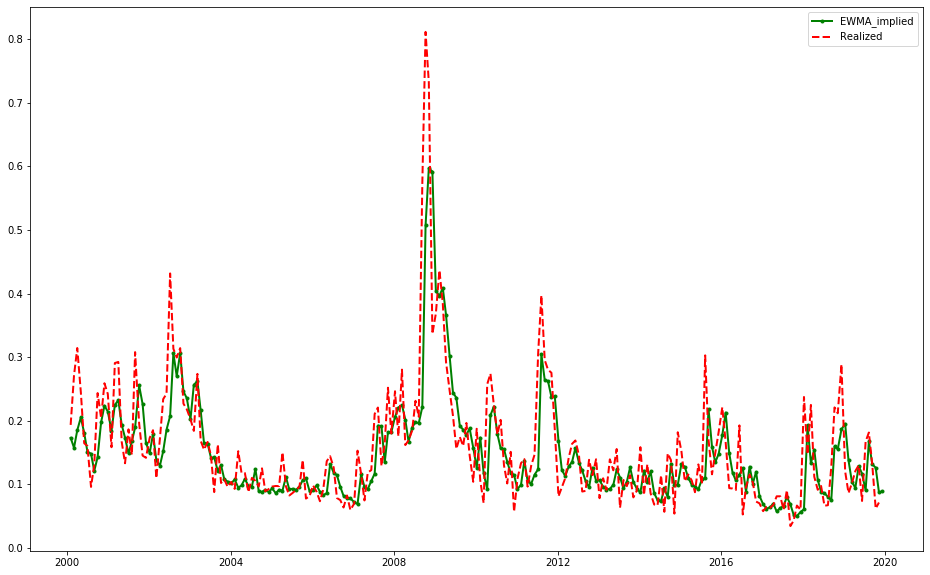

In [95]:
fig, ax = plt.subplots (figsize = (16, 10))

ax.plot(model_ewma_5years, 'g.-', linewidth = 2,  label = 'EWMA_implied')
ax.legend()
ax.plot(realized[realized.index>=model_ewma_5years.index[0]], 'r--', linewidth = 2, label = 'Realized')
ax.legend()


plt.show()

We observe that EWMA & VIX_adj model has the best out of sample performance. Therefore, our next step would be to try to utilize this information in the context of portfolio optimization.

In [97]:
X = model_ewma_5years[:-1]
X.columns = ['EWMA_implied']
X = sm.add_constant(X)
y = realized[(realized.index>=X.index[0]) * (realized.index<=X.index[-1])].copy()

model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    S&P   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     427.5
Date:                Wed, 08 Apr 2020   Prob (F-statistic):           6.90e-55
Time:                        03:01:15   Log-Likelihood:                 336.34
No. Observations:                 238   AIC:                            -668.7
Df Residuals:                     236   BIC:                            -661.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0093      0.008      1.153      0.250      -0.007       0.025
EWMA_implied     0.9998      0.048     20.675      0.000       0.905       1.095
==============================================================================
Omnibus:                      109.360   Durbin-Watson:                   1.653
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              867.201
Skew:                           1.609   Prob(JB):                    4.89e-189
Kurtosis:                      11.780   Cond. No.                         12.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
bear_markets[0].name

In [46]:
x = []
for i in range(len(bear_markets)):
    x.append(bear_markets[i].name)    

In [47]:
x

['March 2000 - October 2002 Crisis',
 'November 2002 - March 2003 Market Correction',
 'October 2007 - March 2009 Crisis',
 'April 2010 - July 2010 Market Correction',
 'April 2011 - October 2011 Market Correction',
 'May 2015 - August 2015 Market Correction ',
 'November 2015 - February 2016 Market Correction ']

In [48]:
lenght = ['929', '104', '517', '70', '157', '96', '100']

In [49]:
cs = pd.concat ([pd.Series (lenght), pd.Series(x)], axis = 1)
cs.columns = ['Lenght', 'Crisis']
cs = cs.set_index('Crisis')

In [54]:
pd.DataFrame(data = lenght, index = x, columns = ['Length'])

,Length
March 2000 - October 2002 Crisis,929
November 2002 - March 2003 Market Correction,104
October 2007 - March 2009 Crisis,517
April 2010 - July 2010 Market Correction,70
April 2011 - October 2011 Market Correction,157
May 2015 - August 2015 Market Correction,96
November 2015 - February 2016 Market Correction,100
